# Quantum Random Access Optimization

In [1]:
from qiskit_optimization.algorithms.qrao import (
    QuantumRandomAccessEncoding,
    SemideterministicRounding,
    QuantumRandomAccessOptimizer,
)
import networkx as nx
from qiskit_optimization.applications import Maxcut

### Set Up the Problem

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_1*x_2 - 2*x_2*x_3 - 2*x_3*x_4 - 2*x_3*x_5
  - 2*x_4*x_5 + 2*x_0 + 2*x_1 + 3*x_2 + 3*x_3 + 2*x_4 + 2*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



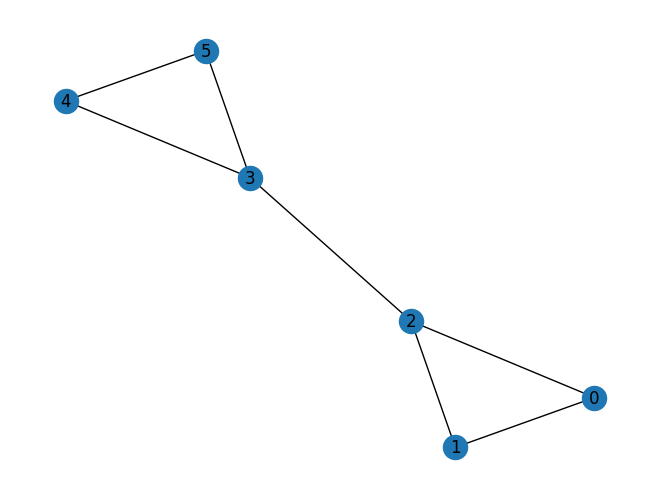

In [2]:
num_nodes = 6



# G = nx.random_regular_graph(d=3, n=num_nodes, seed=seed)
# nx.draw(G, with_labels=True, pos=nx.spring_layout(G, seed=seed))


G = nx.Graph()
G.add_edges_from([(0,1),(1,2),(2,0),(3,2),(4,3),(5,3),(4,5)])
nx.draw_spring(G, with_labels=True)
maxcut = Maxcut(G)
problem = maxcut.to_quadratic_program()
print(problem.prettyprint())

## QRAO Encoding

In [3]:
from qiskit_optimization.algorithms.qrao import QuantumRandomAccessEncoding


# Create an encoding object with a maximum of 3 variables per qubit, aka a (3,1,p)-QRAC
encoding = QuantumRandomAccessEncoding(max_vars_per_qubit=3)

# Encode the QUBO problem into an encoded Hamiltonian
encoding.encode(problem)

# This is our encoded Hamiltonian
print(f"Our encoded Hamiltonian is:\n( {encoding.qubit_op} ).\n")
print(
    "We achieve a compression ratio of "
    f"({encoding.num_vars} binary variables : {encoding.num_qubits} qubits) "
    f"≈ {encoding.compression_ratio}.\n"
)

Our encoded Hamiltonian is:
( SparsePauliOp(['IXX', 'XXI', 'XIX', 'XYI', 'YYI', 'IYY', 'YIY'],
              coeffs=[1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j]) ).

We achieve a compression ratio of (6 binary variables : 3 qubits) ≈ 2.0.



In [4]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Estimator

from qiskit_optimization.algorithms.qrao import (
    QuantumRandomAccessOptimizer,
    SemideterministicRounding,
)


# Prepare the VQE algorithm

ansatz = RealAmplitudes(3)
vqe = VQE(
    ansatz=ansatz,
    optimizer=COBYLA(),
    estimator=Estimator(),
)



# Use semi-deterministic rounding, known as "Pauli rounding"
# in https://arxiv.org/pdf/2111.03167v2.pdf
# (This is the default if no rounding scheme is specified.)
semidterministic_rounding = SemideterministicRounding()

# Construct the optimizer
qrao = QuantumRandomAccessOptimizer(min_eigen_solver=vqe, rounding_scheme=semidterministic_rounding)

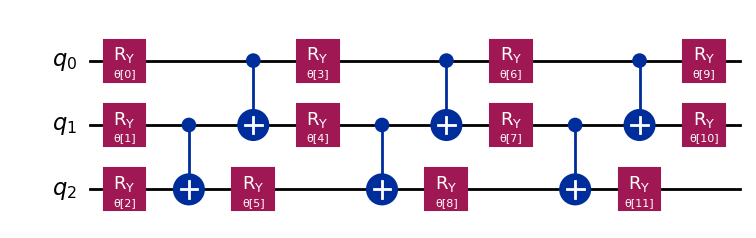

In [5]:
ansatz.decompose().draw(output='mpl',style='iqp')

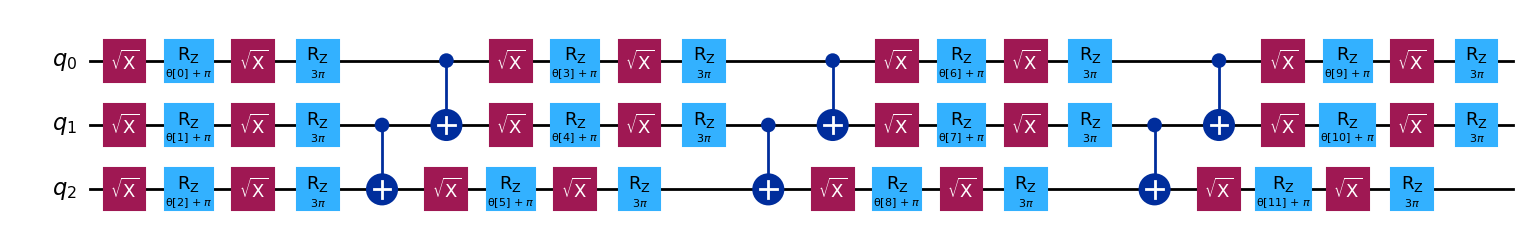

In [6]:
from qiskit import transpile
circuit_basis = transpile(ansatz.decompose(), basis_gates=['cx','rz','sx','x'])
circuit_basis.draw(output='mpl',style='iqp')

## Best Cut

In [7]:
from qiskit.quantum_info import PauliList
observables = PauliList(["ZZZ"])

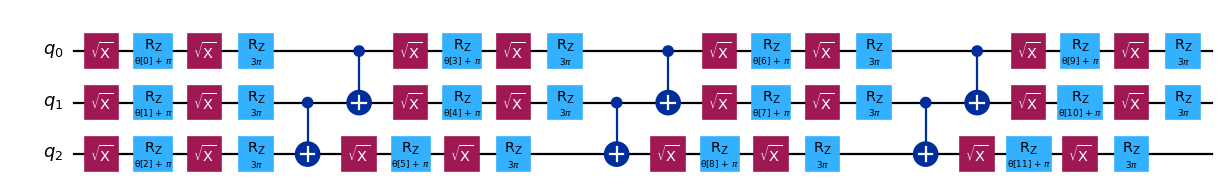

In [9]:
from circuit_knitting.cutting import partition_problem
from circuit_knitting.cutting.cut_finding.cco_utils import qc_to_cco_circuit
circuit_ckt = qc_to_cco_circuit(circuit_basis)

circuit_basis.draw("mpl", scale=0.8,fold=-1,style="iqp")

In [10]:
import numpy as np
from circuit_knitting.cutting.cut_finding.circuit_interface import SimpleGateList
from circuit_knitting.cutting.cut_finding.lo_cuts_optimizer import LOCutsOptimizer
from circuit_knitting.cutting.cut_finding.optimization_settings import (
    OptimizationSettings,
)
from circuit_knitting.cutting.cut_finding.quantum_device_constraints import (
    DeviceConstraints,
)

In [11]:
settings = OptimizationSettings(rand_seed=12345)

settings.set_engine_selection("CutOptimization", "BestFirst")


qubits_per_QPU = 2
num_QPUs = 2


for num_qpus in range(num_QPUs, 1, -1):
    for qpu_qubits in range(qubits_per_QPU, 1, -1):
        print(f"\n\n---------- {qpu_qubits} Qubits per QPU, {num_qpus} QPUs ----------")

        constraint_obj = DeviceConstraints(qubits_per_QPU=qpu_qubits, num_QPUs=num_QPUs)

        interface = SimpleGateList(circuit_ckt)

        op = LOCutsOptimizer(interface, settings, constraint_obj)

        out = op.optimize()

        print(
            " Gamma =",
            None if (out is None) else out.upper_bound_gamma(),
            ", Min_gamma_reached =",
            op.minimum_reached(),
        )
        if out is not None:
            out.print(simple=True)
        else:
            print(out)

        print(
            "Subcircuits:",
            interface.export_subcircuits_as_string(name_mapping="default"),
            "\n",
        )



---------- 2 Qubits per QPU, 2 QPUs ----------
 Gamma = 27.0 , Min_gamma_reached = True
[CutIdentifier(cut_action='CutTwoQubitGate', gate_cut_location=GateCutLocation(instruction_id=13, gate_name='cx')), CutIdentifier(cut_action='CutTwoQubitGate', gate_cut_location=GateCutLocation(instruction_id=27, gate_name='cx')), CutIdentifier(cut_action='CutTwoQubitGate', gate_cut_location=GateCutLocation(instruction_id=41, gate_name='cx'))]
Subcircuits: ABB 



Found solution using 3 cuts with a sampling overhead of 729.0.
Gate Cut at index 13
Gate Cut at index 27
Gate Cut at index 41


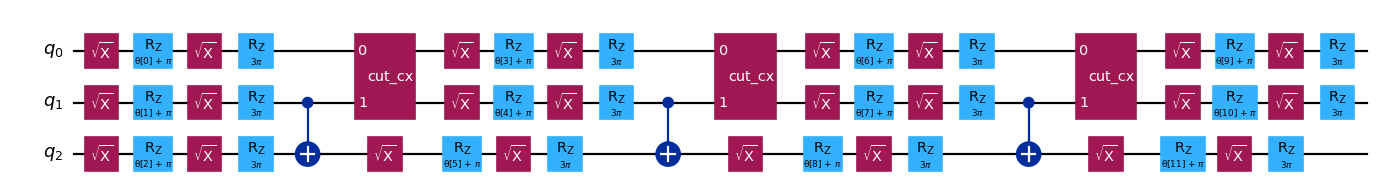

In [12]:
from circuit_knitting.cutting import find_cuts

# Specify settings
optimization_settings = {"rand_seed":111}

# specify device constraints
device_constraints = {"qubits_per_QPU": 2, "num_QPUs": 2}


cut_circuit, metadata = find_cuts(circuit_basis, optimization_settings, device_constraints)
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling '
    f'overhead of {metadata["sampling_overhead"]}.'
)
for cut in metadata["cuts"]:
    print(f"{cut[0]} at index {cut[1]}")
cut_circuit.draw("mpl", scale=0.8, fold=-1,style='iqp')

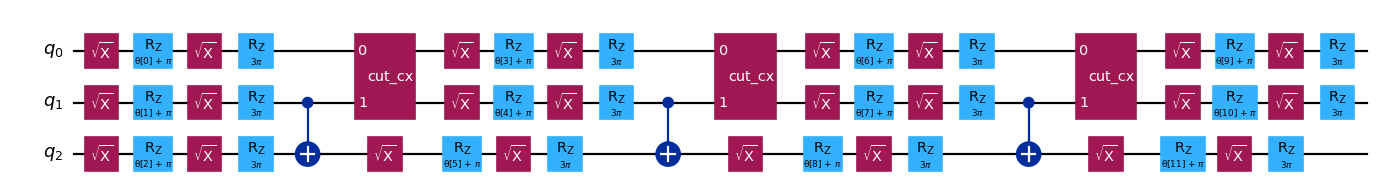

In [13]:
from circuit_knitting.cutting import cut_wires, expand_observables

qc_w_ancilla = cut_wires(cut_circuit)
observables_expanded = expand_observables(observables, circuit_basis, qc_w_ancilla)
qc_w_ancilla.draw("mpl", scale=0.8, fold=-1, style="iqp")

In [14]:
from circuit_knitting.cutting import partition_problem
import numpy as np
partitioned_problem = partition_problem(
    circuit=qc_w_ancilla, observables=observables_expanded
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
print(
    f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem.bases])}"
)

Sampling overhead: 729.0


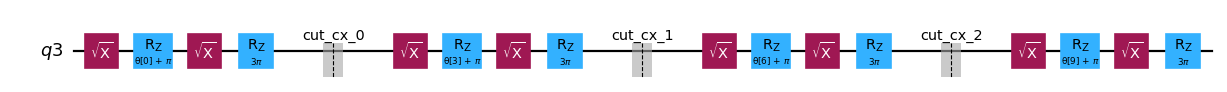

In [15]:
subcircuits[0].draw("mpl", style="iqp", scale=0.8)

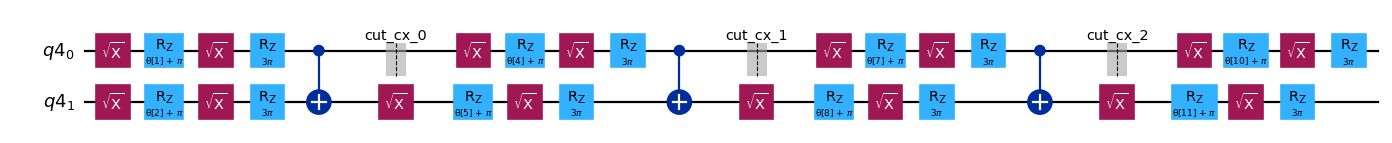

In [16]:
subcircuits[1].draw("mpl", style="iqp", scale=0.8)

In [17]:
from circuit_knitting.cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=1_000
)
print(
    f"{len(subexperiments[0]) + len(subexperiments[1])} total subexperiments to run on backend."
)

432 total subexperiments to run on backend.


In [19]:
from circuit_knitting.cutting import partition_problem

partitioned_problem = partition_problem(
    circuit=circuit_basis, partition_labels="ABB", observables=observables
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases

In [20]:
import numpy as np

print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 729.0


## Generating Subexperiments

In [21]:
from circuit_knitting.cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)

In [22]:
from qiskit_aer.primitives import Sampler

# Set up a Qiskit Aer Sampler primitive for each circuit partition
samplers = {
    label: Sampler(run_options={"shots": 1000}) for label in subexperiments.keys()
}

# Retrieve results from each partition's subexperiments
results = {
    label: sampler.run(subexperiments[label]).result()
    for label, sampler in samplers.items()
}

ValueError: The number of values (0) does not match the number of parameters (4) for the 0-th circuit.

### Reconstruct

In [ ]:
from circuit_knitting.cutting import reconstruct_expectation_values

reconstructed_expvals = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)

In [ ]:
print(reconstructed_expvals)
print(reconstructed_expvals[0])

## VQE

Replace this VQE with a function that evaluates what `res` does.

In [28]:
from gate_cut import *
from qiskit.quantum_info import PauliList
observable = PauliList(['ZZZ'])
expectation = get_expectation(ansatz, "ABB",observable)

In [31]:
vqe = VQE(
    ansatz=ansatz,
    optimizer=COBYLA(),
    estimator=Estimator(),
)

x0 = np.random.rand(ansatz.num_parameters)
# Construct the optimizer
#qrao = QuantumRandomAccessOptimizer(min_eigen_solver=minimize(expectation, x0, method="COBYLA"), rounding_scheme=semidterministic_rounding)
result = QuantumRandomAccessOptimizer(min_eigen_solver=minimize(expectation, x0, method="COBYLA"), rounding_scheme=semidterministic_rounding).solve(problem)

AttributeError: supports_aux_operators

In [ ]:
print(
    f"The objective function value: {results.fval}\n"
    f"x: {results.x}\n"
    f"relaxed function value: {-1 * results.relaxed_fval}\n"
)

In [ ]:
# Solve the optimization problem
results = qrao.solve(problem)

print(
    f"The objective function value: {results.fval}\n"
    f"x: {results.x}\n"
    f"relaxed function value: {-1 * results.relaxed_fval}\n"
)

The obtained solution places a partition between nodes [0, 1, 3] and nodes [2, 4, 5].


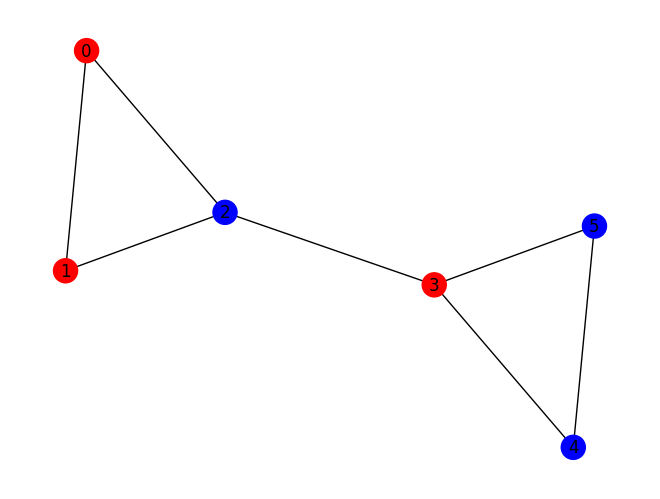

In [12]:
maxcut_partition = maxcut.interpret(results)
print(
    f"The obtained solution places a partition between nodes {maxcut_partition[0]} "
    f"and nodes {maxcut_partition[1]}."
)
maxcut.draw(results, pos=nx.spring_layout(G, seed=12))

